# Using micrograd 
Implementing one forward and backward pass with visualization for clarity

In [1]:
import random
import math

In [2]:
class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self,other):
        return self+other
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self*other
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'^{other}')

        def _backward():
            self.grad += other*(self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (-1 * other)

    def __truediv__(self,other):
        return self * other**-1
    

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out    
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) -1)/(math.exp(2*n) + 1)
        out = Value(t, (self,),'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def neglog(self):
        n = self.data
        l = -(math.log(n))
        out = Value(l,(self,),'-log')

        def _backward():
            self.grad += l**(-1) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def zero_grad(self):
        self.grad = 0.0

In [3]:
from graphviz import Digraph

def trace(root):

    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name =uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data,n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
# Initial parameters
x1 = Value(1.0,label='x1')
x2 = Value(2.0,label='x2')
x3 = Value(3.0,label='x3')
b = Value(random.random(), label='b')
c = Value(random.random(), label='c')
h0 = Value(random.random(), label='h0')
W = Value(random.random(), label='W')
U = Value(random.random(), label='U')
V =Value(random.random(), label='V')


In [7]:
#forward pass
#time step: 1
a1 = b + W*h0 + U*x1; a1.label='a1'
h1 = a1.tanh(); h1.label = 'h1'
o1 = c + V*h1; o1.label = 'o1'
y1 = o1; y1.label= 'y1'
#time step: 2
a2 = b + W*h1 + U*x2; a2.label = 'a2'
h2 = a2.tanh(); h2.label = 'h2'
o2 = c + V*h2; o2.label = 'o2'
y2 = o2; y2.label= 'y2'
#time step: 3
a3 = b + W*h2 + U*x3; a3.label = 'a3'
h3 = a3.tanh(); h3.label = 'h3'
o3 = c + V*h3; o3.label = 'o3'
y3 = o3; y3.label= 'y3'

# negative loss likelihood
loss = (y1.neglog() + y2.neglog() + y3.neglog()) / 3

Softmax was not used as there was only one element given as the output.

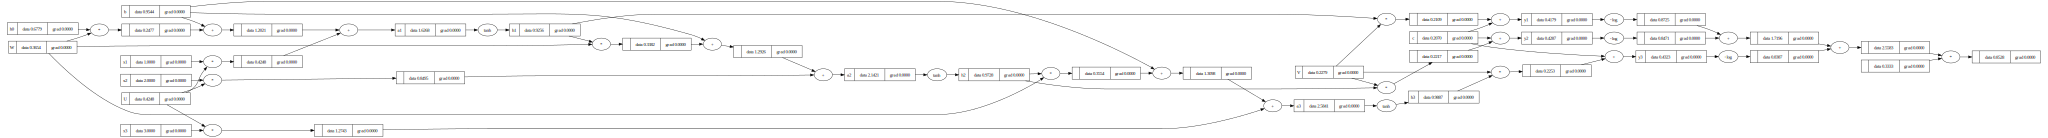

In [8]:
draw_dot(loss)

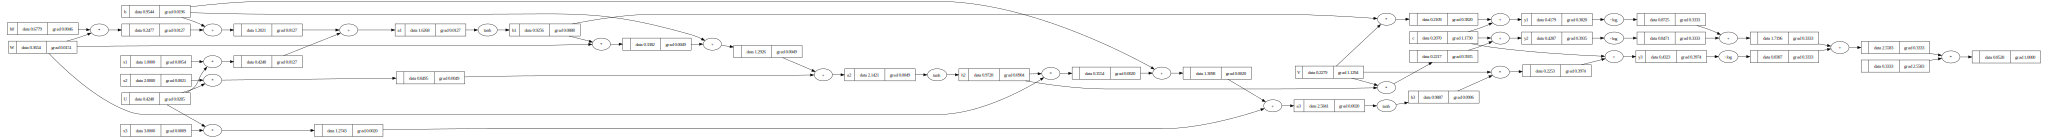

In [9]:
#backward pass
loss.grad = 1.0
loss.backward()
draw_dot(loss)